In [ ]:
!pip install keras-unet-collection albumentations tensorflow==2.5.0 keras==2.5.0 
DRIVE_PATH = "/content/drive/MyDrive/Datasets/Cell-Image-Segmentation/split_data.zip"
!unzip $DRIVE_PATH -d /content
!mv content/split_data /content
!rm -rf content
# !pip install split-folders
# import splitfolders
# !mkdir split_data
# splitfolders.ratio(
#     '/content/aug_normal_data',
#     '/content/split_data',
#     seed=420,
#     ratio=(.8, .2),
#     group_prefix=None
# )
# !zip -r /content/drive/MyDrive/Datasets/Cell-Image-Segmentation/split_data.zip /content/split_data

     |████████████████████████████████| 67 kB 3.1 MB/s 
     |████████████████████████████████| 454.3 MB 17 kB/s 
ERROR: Could not find a version that satisfies the requirement keras==2.5.0 (from versions: 0.2.0, 0.3.0, 0.3.1, 0.3.2, 0.3.3, 1.0.0, 1.0.1, 1.0.2, 1.0.3, 1.0.4, 1.0.5, 1.0.6, 1.0.7, 1.0.8, 1.1.0, 1.1.1, 1.1.2, 1.2.0, 1.2.1, 1.2.2, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.0.5, 2.0.6, 2.0.7, 2.0.8, 2.0.9, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.1.5, 2.1.6, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.2.4, 2.2.5, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.5.0rc0, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0rc3, 2.6.0, 2.7.0rc0, 2.7.0rc2, 2.7.0)
ERROR: No matching distribution found for keras==2.5.0
Archive:  /content/drive/MyDrive/Datasets/Cell-Image-Segmentation/split_data.zip
   creating: /content/content/split_data/
   creating: /content/content/split_data/val/
   creating: /content/content/split_data/val/image/
  inflating: /content/content/split_data/val/image/normal_3_1.png  
  inflating: /content/c

In [ ]:
!pip install keras-unet-collection

  Using cached keras_unet_collection-0.1.11-py3-none-any.whl (67 kB)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import (Conv2D, Conv2DTranspose,
                          MaxPooling2D, Dropout,
                          concatenate)
from keras import Model
from keras_unet_collection.losses import dice
import os
import glob
from tqdm import tqdm
import cv2 
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# !mv /content/content/split_data /content
# !rm -rf content
# DRIVE_PATH = "/content/drive/MyDrive/Datasets/Cell-Image-Segmentation/split_data.zip"
# !unzip $DRIVE_PATH 

In [ ]:
!rm -rf aug*
import os
import cv2
import random 
import albumentations as A
from numpy import promote_types
from scipy.ndimage import rotate
from skimage import io, img_as_ubyte
from skimage import transform
from skimage.transform import AffineTransform, warp

TOTAL_IMAGES = 180
IMAGE_WIDTH = 320
IMAGE_HEIGHT = int(0.8 * IMAGE_WIDTH)

# IMAGE_HEIGHT = 384
# IMAGE_WIDTH = 480
DATA_DIR = "/content/split_data"
TRAIN_IMG_DIR = os.path.join(DATA_DIR, 'train', 'image')
TRAIN_MSK_DIR = os.path.join(DATA_DIR, 'train', 'mask')
VALID_IMG_DIR = os.path.join(DATA_DIR, 'val', 'image')
VALID_MSK_DIR = os.path.join(DATA_DIR, 'val', 'mask')

train_images = [os.path.join(TRAIN_IMG_DIR, i) for i in sorted(os.listdir(TRAIN_IMG_DIR))]
train_masks = [os.path.join(TRAIN_MSK_DIR, i) for i in sorted(os.listdir(TRAIN_MSK_DIR))]
valid_images = [os.path.join(VALID_IMG_DIR, i) for i in sorted(os.listdir(VALID_IMG_DIR))]
valid_masks = [os.path.join(VALID_MSK_DIR, i) for i in sorted(os.listdir(VALID_MSK_DIR))]
aug_train_images = "augmented/train/images"
aug_train_masks = "augmented/train/masks"
aug_valid_images = "augmented/valid/images"
aug_valid_masks = "augmented/valid/masks"

train_transforms = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=35, p=0.6),
    A.ElasticTransform(
        p=0.5, 
        border_mode = cv2.BORDER_CONSTANT, 
        interpolation = cv2.INTER_AREA
    )
])

valid_transforms = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
])

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def augger(images, masks, transform, total, aug_image_path, aug_mask_path):
    i = 1
    # while i <= total:
    for i in tqdm(range(1, total+ 1), total=total):
        number = random.randint(0, len(images)-1)  #PIck a number to select an image & mask
        image = images[number]
        mask = masks[number]
        
        # print(image, mask)
        #image=random.choice(images) #Randomly select an image name
        original_image = io.imread(image)
        original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
        original_mask = io.imread(mask)
        # print(original_image.shape,original_mask.shape)
        # plt.subplot(133)
        # plt.imshow(original_image[:,:,1])
        augmented = transform(image=original_image, mask=original_mask)
        transformed_image = augmented['image']
        transformed_mask = augmented['mask']
            
        # new_image_path= "augmented_image_%s.png" %(i)
        # new_mask_path = "augmented_mask_%s.png" %(i)
        new_image_path = os.path.join(aug_image_path, f"augmented_image_{i}.png")
        new_mask_path = os.path.join(aug_mask_path, f"augmented_mask_{i}.png")
        io.imsave(new_image_path, transformed_image)
        io.imsave(new_mask_path, transformed_mask)
        # break
        i += 1
    


create_dir(aug_train_images)
create_dir(aug_train_masks)
create_dir(aug_valid_images)
create_dir(aug_valid_masks)

augger(
    images=train_images,
    masks=train_masks,
    transform = train_transforms,
    total=TOTAL_IMAGES,
    aug_image_path = aug_train_images,
    aug_mask_path = aug_train_masks
)

 23%|██▎       | 41/180 [00:09<00:36,  3.80it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: UserWarning: augmented/train/masks/augmented_mask_42.png is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: UserWarning: augmented/train/masks/augmented_mask_43.png is a low contrast image
 49%|████▉     | 88/180 [00:18<00:16,  5.49it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: UserWarning: augmented/train/masks/augmented_mask_89.png is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: UserWarning: augmented/train/masks/augmented_mask_90.png is a low contrast image
 60%|██████    | 108/180 [00:22<00:11,  6.29it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: UserWarning: augmented/train/masks/augmented_mask_109.png is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: UserWarning: augmented/train/masks/augmented_mask_110.png i

In [53]:
IMAGE_WIDTH = 320
IMAGE_HEIGHT = int(0.8 * IMAGE_WIDTH)
TRAIN_IMG_DIR = "/content/augmented/train/images"
TRAIN_MSK_DIR = "/content/augmented/train/masks"
#### LOAD DATA
train_images = []
train_masks = []
images_paths = sorted([os.path.join(TRAIN_IMG_DIR, i) for i in os.listdir(TRAIN_IMG_DIR)])
masks_paths = sorted([os.path.join(TRAIN_MSK_DIR, i) for i in os.listdir(TRAIN_MSK_DIR)])
for i, (X,Y) in tqdm(enumerate(zip(images_paths, masks_paths)), total=len(images_paths)):
    img = cv2.imread(X, 0)
    mask = cv2.imread(Y, 0)
    mask = np.where(mask > 0, 255, mask)
    train_images.append(img)
    train_masks.append(mask)
    # plt.subplot(121)
    # plt.imshow(mask)
    # plt.subplot(122)
    # plt.imshow(img)
    # print(img.shape, mask.shape)
    # break
train_images = np.array(train_images, dtype=np.float32)/255.0
train_masks = np.array(train_masks, dtype=np.float32)/255.0


100%|██████████| 180/180 [00:00<00:00, 605.42it/s]


In [54]:
X = train_images
Y = train_masks
print(X.shape, Y.shape)
X = np.expand_dims(X, axis=3)
Y = np.expand_dims(Y, axis=3)
print(X.shape, Y.shape)
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

(180, 256, 320) (180, 256, 320)
(180, 256, 320, 1) (180, 256, 320, 1)


In [55]:
from simple_unet import define_model

In [56]:
define_model??

In [57]:
from keras_unet_collection.losses import dice_coef
model = define_model(1, IMAGE_HEIGHT, IMAGE_WIDTH, 1)
model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=[dice_coef]
)

In [58]:
from keras.callbacks import ModelCheckpoint, TensorBoard
checkpoint = ModelCheckpoint('model_unet_cell_seg_v2.h5', save_best_only=True)

In [59]:
!mkdir -p /content/logs/fit
tb = TensorBoard(log_dir='logs/fit/', histogram_freq=1)

In [60]:
history = model.fit(
    x = x_train, 
    y = y_train,
    batch_size = 12,
    epochs = 15,
    validation_data = (x_val, y_val),
    shuffle = False,
    callbacks = [tb, checkpoint])

Epoch 1/15
12/12 [==============================] - 32s 3s/step - loss: 0.9818 - dice_coef: 0.3616 - val_loss: 0.6612 - val_dice_coef: 0.4040
Epoch 2/15
12/12 [==============================] - 29s 2s/step - loss: 0.6436 - dice_coef: 0.4357 - val_loss: 0.6094 - val_dice_coef: 0.4528
Epoch 3/15
12/12 [==============================] - 29s 2s/step - loss: 0.5783 - dice_coef: 0.4971 - val_loss: 0.5372 - val_dice_coef: 0.5161
Epoch 4/15
12/12 [==============================] - 29s 2s/step - loss: 0.5083 - dice_coef: 0.5410 - val_loss: 0.4210 - val_dice_coef: 0.6065
Epoch 5/15
12/12 [==============================] - 29s 2s/step - loss: 0.2610 - dice_coef: 0.7453 - val_loss: 0.1068 - val_dice_coef: 0.8920
Epoch 6/15
12/12 [==============================] - 29s 2s/step - loss: 0.1644 - dice_coef: 0.8592 - val_loss: 0.1054 - val_dice_coef: 0.8888
Epoch 7/15
12/12 [==============================] - 28s 2s/step - loss: 0.1157 - dice_coef: 0.8738 - val_loss: 0.1373 - val_dice_coef: 0.8206
Epoch 

In [61]:
history.history.keys()

dict_keys(['loss', 'dice_coef', 'val_loss', 'val_dice_coef'])

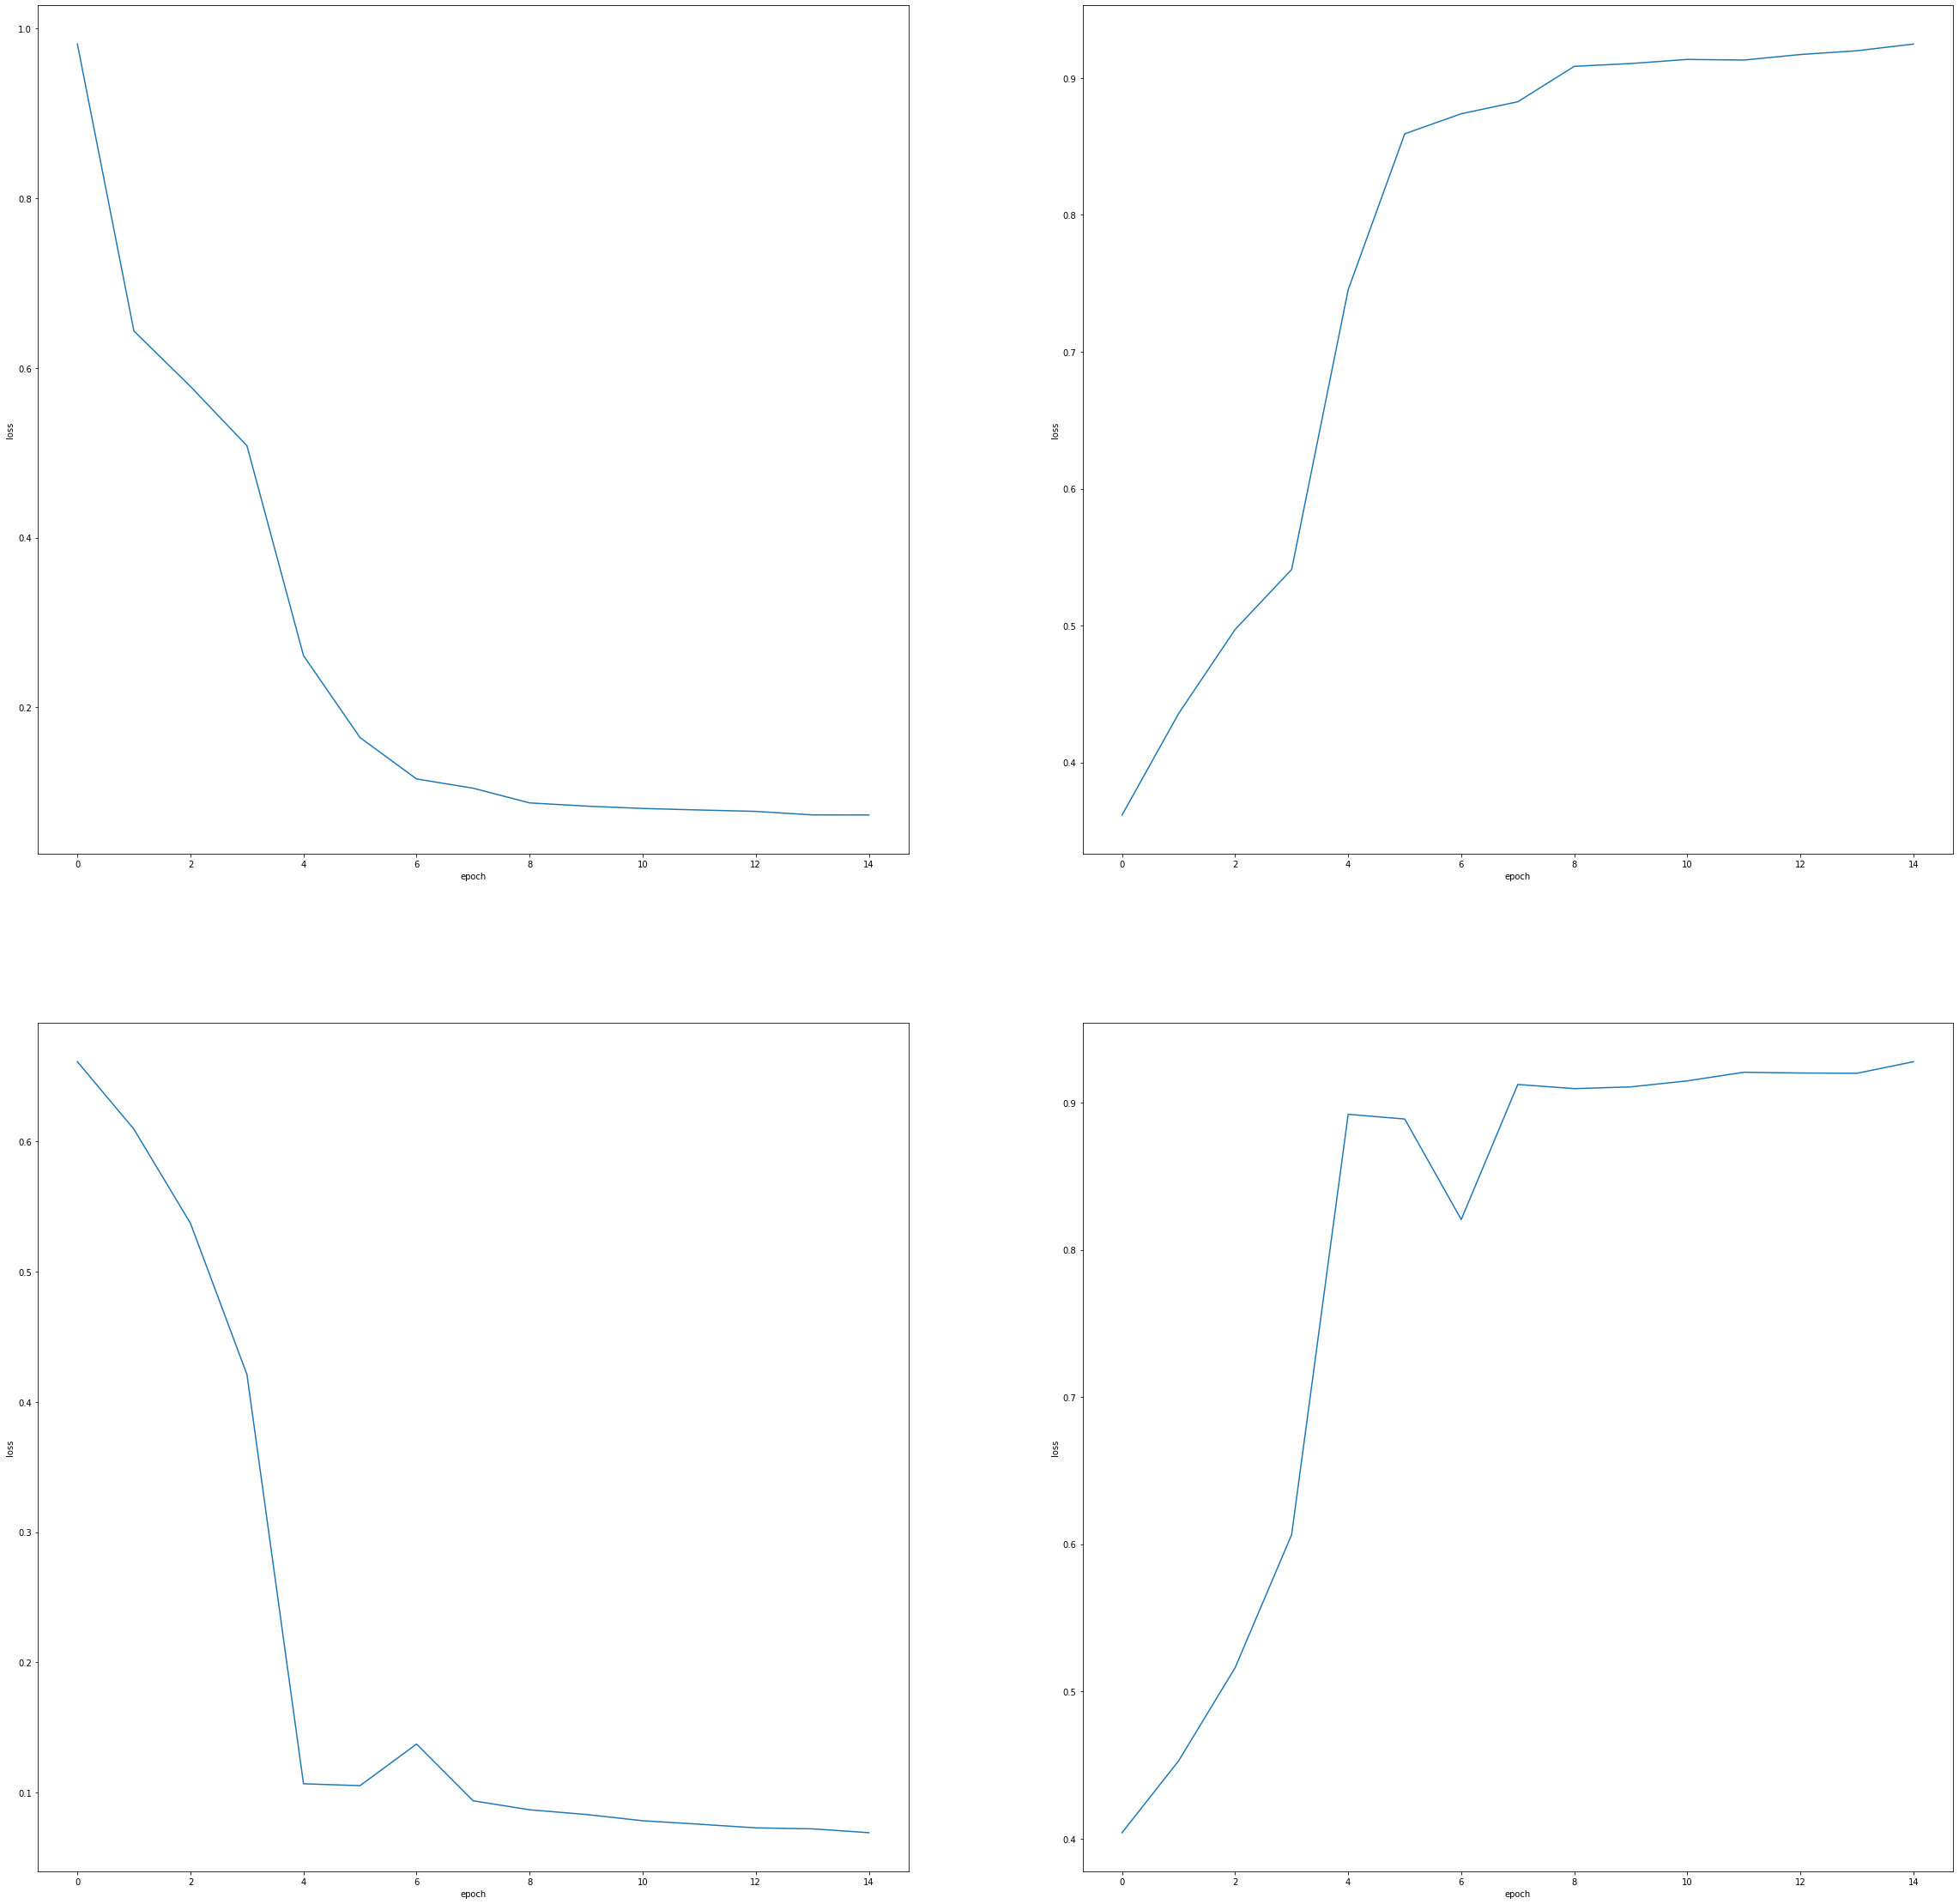

In [62]:
X = np.arange(5)
plt.rcParams['figure.figsize'] = (40,40)

for i,m in enumerate([221,222, 223, 224]):
    plt.subplot(m)
    plt.plot(history.history[list(history.history.keys())[i]])
    plt.ylabel('loss')
    plt.xlabel('epoch')
plt.show()

In [63]:
x_test, y_test = [], []
test_img = "/content/split_data/val/image" 
test_msk = "/content/split_data/val/mask"
test_images = sorted([os.path.join(test_img, i) for i in os.listdir(test_img)])
test_masks = sorted([os.path.join(test_msk, i) for i in os.listdir(test_msk)])

for i, (x, y) in tqdm(enumerate(zip(test_images, test_masks)), total=len(test_images)):
    # original_image = io.imread(x)
    # original_mask = io.imread(y)
    original_image = io.imread(x)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    original_mask = io.imread(y)
    original_mask = np.where(original_mask > 0, 255, original_mask)
    augmented = valid_transforms(image=original_image, mask=original_mask)
    transformed_image = augmented['image']
    transformed_mask = augmented['mask']
    # transformed_mask = np.where(transformed_mask > 0, 255, transformed_mask)
    # transformed_image = transformed_image.astype(np.float32)
    # transformed_mask = transformed_mask.astype(np.float32)
    x_test.append(transformed_image)
    y_test.append(transformed_mask)

    # plt.subplot(121)
    # plt.imshow(transformed_image)
    # plt.subplot(122)
    # plt.imshow(transformed_mask)
    # break
x_test = np.array(x_test, dtype=np.float32)/255.0
y_test = np.array(y_test, dtype=np.float32)/255.0
x_test = np.expand_dims(x_test, axis = 3)
y_test = np.expand_dims(y_test, axis = 3)

100%|██████████| 33/33 [00:02<00:00, 15.65it/s]


In [64]:
preds = model.predict(x_test, batch_size=8)

7 tf.Tensor(0.05012399, shape=(), dtype=float32)


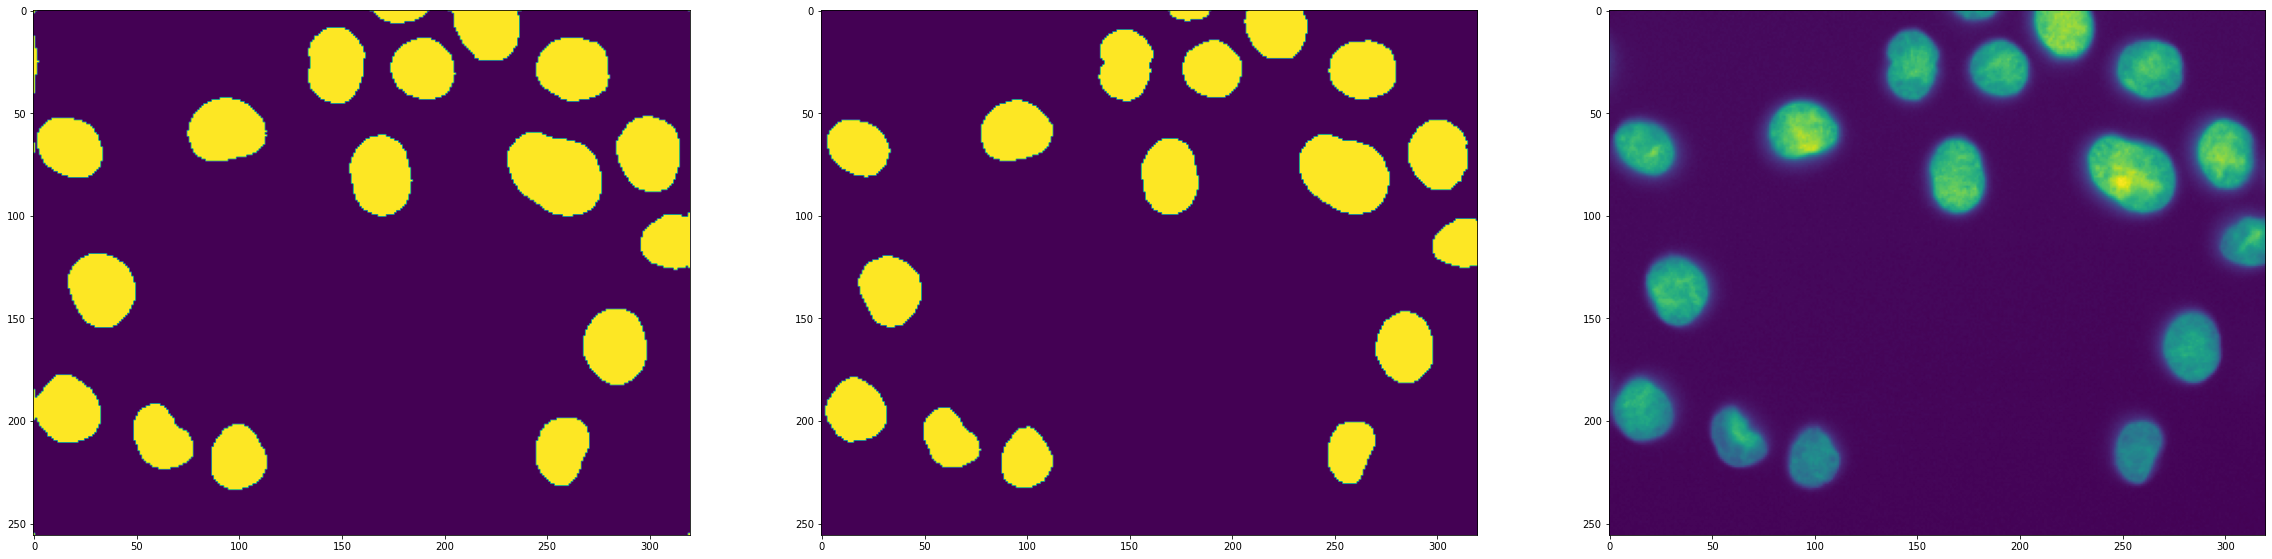

In [66]:
import random
i = random.randint(0,len(preds))
plt.subplot(131)
plt.imshow(np.reshape(np.where(preds[i] > 0.05, 255, 0), (IMAGE_HEIGHT, IMAGE_WIDTH)))
# plt.imshow(np.reshape(preds[i] , (IMAGE_HEIGHT, IMAGE_WIDTH)))
plt.subplot(132)
plt.imshow(np.reshape(y_test[i] , (IMAGE_HEIGHT, IMAGE_WIDTH)))
plt.subplot(133)
plt.imshow(np.reshape(x_test[i] , (IMAGE_HEIGHT, IMAGE_WIDTH)))
print(i, dice(preds[i], y_test[i]))